In [2]:
import pandas as pd
import time
import datetime
import numpy as np


import prob_tree
import kTree
from fractions import Fraction
import graphviz
import tree
from kTree import ktree_main

import sys
import generators
import numpy as np
import math
from data import Data
from datetime import datetime, timedelta

import os
import pickle
import json

data_train1 = pd.read_csv('./input_data/Future/20190620/IH1906.CFFEX.txt',header=0)



In [3]:
f = open("./input_data/Future/mid_volume_train_IH_1min_20180102.txt", "rb")  
price_train1=pickle.load(f)
f.close()
type(price_train1)
price_train1.head()

1514885400500000    2876.422222
1514885401000000    2876.755556
1514885401500000    2877.280000
1514885402000000    2878.200000
1514885402500000    2877.533333
dtype: float64

In [4]:
###Functions to make prediction based on CTW model

#prediction function based on the maximum likelihood tree
#input: trained tree model, the previous data to make prediction
#output: probability list of the next state
def predict_one_tree(KTreeNode_,data): 
    d = len(data)
    node = KTreeNode_
    for pos in range(1, d):
        if (node.children[data[-pos]]==None):
            break
        node = node.children[data[-pos]]
    sum_=sum(node.count)
    #print(node.count)
    prob_pred = [c/sum_ for c in node.count]
    return prob_pred 

#prediction function based on the first k maximum likelihodd trees
#input: trained tree models, the previous data to make prediction
#output: probability list of the next state
def predict_weighted_trees(trees,data): 
    n = len(trees)
    m = trees[0][0].m
    prob = [0. for _ in range(m)]
    sum_weight = 0.
    for i in range(0,n):
        prob_pred = predict_one_tree(trees[i][0],data)
        sum_weight += trees[i][1]
        for j in range(0,m):
            prob[j] += trees[i][1] * prob_pred[j]
    prob_weighted = [p/sum_weight for p in prob]
    return prob_weighted 

In [5]:
###Functions to test the prediction of CTW model

#function to train the model using the previous n days data, test the model on the testing data, and implement strategy based on the prediction
#input: the date of the test data, the frequence of the treated data (time interval of data = frequence*0.5s), number of days for training data
#output: class prediction correct rate, direction prediction correct rate, correlation of predicted class and real class, strategy trading volume
def flexible_test(date_test,freq,num_train_days):
    
    #read the training data
    date_test_d = datetime(year=int(str(date_test)[0:4]), month=int(str(date_test)[4:6]), day=int(str(date_test)[6:8]))
    date_date =  date_test_d-timedelta(days=1)  
    date = 10000*date_date.year + 100*date_date.month + date_date.day
    i = 0
    return_train=[]
    
    while i<num_train_days:
        path = './input_data/Future/mid_volume_train_IH_1min_'+str(date)+'.txt'
        #path = './input_data/Future/2mid_volume_train_IC_'+str(date)+'.txt'
        date_date = datetime(year=int(str(date)[0:4]), month=int(str(date)[4:6]), day=int(str(date)[6:8]))
        if os.access(path, os.F_OK):
            i += 1  
            f = open(path, "rb")  
            price_train = pickle.load(f)
            f.close()
            price_index = [x * freq for x in list(range(int(len(price_train)/freq)))]
            price_train_ = price_train.iloc[price_index]

            price_train_1 = price_train_[:(len(price_train_)-1)]
            price_train_2 = price_train_[1:len(price_train_)]
            price_train_1.index = price_train_2.index
            return_train_ = (price_train_2/price_train_1-1)*100
            locals()['return_train'+str(i)] = return_train_.tolist()
            return_train.extend(locals()['return_train'+str(i)])
        date_date =  date_date-timedelta(days=1) 
        date = 10000*date_date.year + 100*date_date.month + date_date.day


    #classify the training returns
    return_train_class_total = []
    thres1 = np.percentile(return_train,25)
    thres2 = np.percentile(return_train,50)
    thres3 = np.percentile(return_train,75)
    for d in return_train:
        v = None
        if d <= thres1:
            v = 0
        elif thres1 < d and d <= thres2:
            v = 1
        elif thres2 < d and d <= thres3:
            v = 2
        elif d > thres3:
            v = 3
        return_train_class_total.append(v)

    fileObject = open('return_class_train.txt', 'w')
    fileObject.write('[')
    for ip in return_train_class_total[:-1]:
        ip=str(ip)
        fileObject.write(ip)
        fileObject.write(',')
    fileObject.write(str(return_train_class_total[-1]))
    fileObject.write(']')
    fileObject.close()
    
    #train the trees
    D = 9
    beta = Fraction(1, 2)
    top, trees = ktree_main(return_train_class_total, m=max(return_train_class_total)+1, D=D, k=5, beta=beta)

    pw = top.pw
    trees_probs = [(t, t.compute_pi_T_x(beta, D, pw)) for t, _ in trees]
    # print(graphviz.multiple_trees_to_html(trees_probs, only_struct=True))
    
    #read the testing data and classify the testing returns
    path = './input_data/Future/mid_volume_train_IH_1min_'+str(date_test)+'.txt'
    #path = './input_data/Future/2mid_volume_train_IC_'+str(date_test)+'.txt'
    f = open(path, "rb")  
    price_test = pickle.load(f)
    price_index = [x * freq for x in list(range(int(len(price_test)/freq)))]
    price_test_ = price_test.iloc[price_index]
    price_test_1 = price_test_[:(len(price_test_)-1)]
    price_test_2 = price_test_[1:len(price_test_)]
    price_test_1.index = price_test_2.index
    return_test = (price_test_2/price_test_1-1)*100
    price_test_1=price_test_1.tolist()
    return_test = return_test.tolist()
   
    return_test_class_total = []

    for d in return_test:
        v = None
        if d <= thres1:
            v = 0
        elif thres1 < d and d <= thres2:
            v = 1
        elif thres2 < d and d <= thres3:
            v = 2
        elif d > thres3:
            v = 3
        return_test_class_total.append(v)

    return_test_class_input = return_test_class_total[(10-10):]
    return_test_class_real = return_test_class_total[10:]
    return_test_real = return_test[10:]
    price_test_real = price_test_1[10:]
    
    #make predictions using the trained tree
    return_test_class_predicted_one=[]
    for i in range(10, len(return_test_class_input)):
        pred_prob = predict_one_tree(trees_probs[0][0],return_test_class_input[(i-10):i])
        return_test_class_predicted_one.append(pred_prob.index(max(pred_prob)))

    #calculate the class prediction correct rate
    co = 0
    for i in range(len(return_test_class_predicted_one)):
        if (return_test_class_predicted_one[i] == return_test_class_real[i]):
            co += 1
    class_correct_rate=co/len(return_test_class_predicted_one)
    
    #calculate the direction prediction correct rate
    co1,co2,sum1,sum2 = 0,0,0,0
    for i in range(len(return_test_class_predicted_one)):
        if (return_test_class_real[i] in range(2,4)):
            sum2 += 1
            if (return_test_class_predicted_one[i] in range(2,4)):
                co2 += 1
        elif (return_test_class_real[i] in range(0,2)):
            sum1 += 1
            if (return_test_class_predicted_one[i] in range(0,2)):
                co1 += 1
    #print(co1,sum1,co2,sum2)
    direction_correct_rate=(co1+co2)/(sum1+sum2)
    print(co1,sum1,co2,sum2)
    
    #implement the strategy based on the prediction of the tree
    portf_value = []
    portf_value.append(1.)
    pt_value=0.
    len_test= len(return_test_class_real)
    pos0=0
    pos1=0
    poscum=0
    profit=[]
    for i in range(len_test-1): #4788-1
        if(return_test_class_predicted_one[i+1] in range(2,4)):
            pt_value = pt_value+price_test_1[-len_test+1+i]*return_test[-len_test+1+i]/100
            #print([+1,return_test_class_predicted_one[i+1],price_test_1[-len_test+1+i]*return_test[-len_test+1+i]/100,price_test_1[-len_test+1+i],return_test[-len_test+1+i]/100])
            pos1=1
        else:
            pt_value = pt_value-price_test_1[-len_test+1+i]*return_test[-len_test+1+i]/100            
            #print([-1,return_test_class_predicted_one[i+1],-price_test_1[-len_test+1+i]*return_test[-len_test+1+i]/100,price_test_1[-len_test+1+i],return_test[-len_test+1+i]/100])
            pos1=-1
        profit.append(abs(price_test_1[-len_test+1+i]*return_test[-len_test+1+i]/100))  
        poscum=poscum+abs(pos1-pos0)
        pos0=pos1
        portf_value.append(pt_value)
     
    #plot the strategy pnl
    import matplotlib.pyplot as plt
    plt.plot(portf_value)
    plt.xlabel('t')
    plt.ylabel('pnl')
    name="pnl_IH_"+str(date_test)
    plt.title(name)
    plt.savefig(name+".png")
    plt.figure()
    
    cor = np.corrcoef([return_test_class_predicted_one,return_test_class_real])[0,1]
    return class_correct_rate, direction_correct_rate, cor, poscum
#     return portf_value


    

Building full tree
Building counts
Computing probas
Building matrix
Extracting tree 0
Extracting tree 1
Extracting tree 2
Extracting tree 3
Extracting tree 4


15711 18486 2846 10304


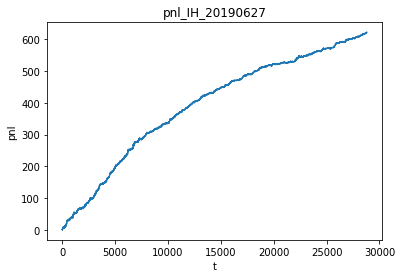

<Figure size 432x288 with 0 Axes>

In [7]:
x,y,z,p=flexible_test(20190627,1,1)